# Extraction of Reddit Posts:
1. Reddit extractions : experiment.py to see how I extracted the reddit data files
2. Topics extractions : please refer to the procedures below and the findings)
3. Dash Visualization : dash-main.py to see how I visualize it in dash deployed locally 

# Reading  CSV

In [ ]:
import pandas as pd

In [9]:
df = pd.read_csv('topics.csv')
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Someone in our class Slack channel told a TA t...,117,asfegl,https://i.redd.it/y0avy3bzalh21.png,35,1.550610e+09,NaN,2019-02-20 05:05:22
1,Come gather ye doubting OMSCS students so I ca...,113,amz999,https://www.reddit.com/r/OMSCS/comments/amz999...,30,1.549264e+09,I'm relatively new here. Just joined the progr...,2019-02-04 15:13:14
2,Fall 2019 Admissions Thread,91,ahr3kw,https://www.reddit.com/r/OMSCS/comments/ahr3kw...,702,1.547937e+09,**General Info**\r\n\r\n**Apply Here:** [http:...,2019-01-20 06:30:45
3,WL ACT,80,9736dr,https://i.redd.it/9rv0enkh0yf11.jpg,13,1.534202e+09,NaN,2018-08-14 07:12:04
4,They say a Masters is for personal fulfilment ...,82,a5vz21,https://www.reddit.com/r/OMSCS/comments/a5vz21...,26,1.544725e+09,"After getting my grade back today, and being a...",2018-12-14 02:09:24


# Topic extractions

This section illustrates how to do approximate topic modeling in Python. We will use a technique called non-negative matrix factorization (NMF) that strongly resembles Latent Dirichlet Allocation (LDA) which is used to find extract topics from bags of words (list of words)

Preparing data for topic extractions by making texts into bags of words

In [13]:
# Importing necessary model values
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Getting the X_train
X_train = df.title
print(X_train.head())

0    Someone in our class Slack channel told a TA t...
1    Come gather ye doubting OMSCS students so I ca...
2                          Fall 2019 Admissions Thread
3                                               WL ACT
4    They say a Masters is for personal fulfilment ...
Name: title, dtype: object


In [14]:
# tokenize and vectorize the words inside the list of documents/tweets
vectorizer = CountVectorizer(stop_words='english')
X_train_dtm = vectorizer.fit_transform(X_train)
vocab = np.array(vectorizer.get_feature_names())

print(X_train_dtm.shape)
print(len(vocab))

(500, 1115)
1115


# Generating Decomposition Model to extract topic
By analogy with LDA, we will use NMF to get a document-topic matrix (topics here will also be referred to as “components”) and a list of top words for each topic. We will make analogy clear by using the same variable names: doctopic and topic_words

In [42]:
# Using sklearn library to get the necessary LDA model
from sklearn import decomposition

num_topics = 5
num_top_words = 5
clf = decomposition.NMF(n_components=num_topics, random_state=1)

# this next step may take some time to train depending on the texts you have
doctopic = clf.fit_transform(X_train_dtm)
doctopic.shape

(500, 5)

In [43]:
clf.components_.shape

(5, 1115)

In [44]:
clf.components_

array([[0.0191221 , 0.        , 0.01366659, ..., 0.02848163, 0.        ,
        0.07115806],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04238556,
        0.        ],
       [0.04941312, 0.13117592, 0.09293894, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00399071, ..., 0.02689728, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [45]:
# Getting the dominant topic for each word
topic_words = []

# Appending top important vocabset list onto topic_words list
for topic in clf.components_:
#     npargsort gets the index based on the order, [::-1] order it descending and finally num_top_words will filter it
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [46]:
topic_words[:1]

[['omscs', 'program', 'students', 'job', 'course']]

In [47]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t+1, ' '.join(topic_words[t][:15])))

Topic 1: omscs program students job course
Topic 2: cs undergrad degree non reviews
Topic 3: georgia tech online master program
Topic 4: courses classes semester students new
Topic 5: time did job offer commitment


We can see here that the model did a good job in finding bags of words of 5 and find 5 clusters to group these words together with.

# Visualizing the topics

In [48]:
import matplotlib.pyplot as plt

# Making DataFrame that gets the doctopic (values of topics for each text)
dftopic = pd.DataFrame(doctopic,columns=topic_words)
dftopicinv=dftopic.T

# Getting the dominant topic
topic_series = []
for i in np.arange(dftopic.shape[0]):
    topic_series.append(dftopicinv[i].argmax())

dftopic['dominanttopic'] = topic_series
df['dominanttopic'] = topic_series

print(dftopic.shape)
print(df.shape)

(500, 6)
(500, 9)


C:\new_software\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  # Remove the CWD from sys.path while we load stuff.


(job, non, master, students, offer)            206
(omscs, cs, georgia, courses, time)            118
(program, undergrad, tech, classes, did)        61
(course, reviews, program, new, commitment)     60
(students, degree, online, semester, job)       55
Name: dominanttopic, dtype: int64


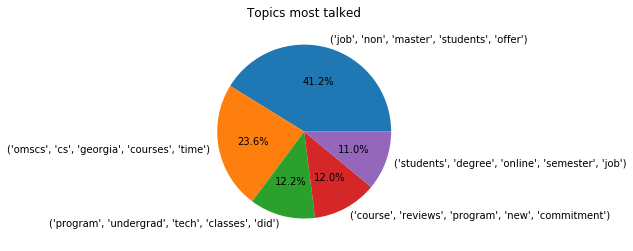

In [49]:
# Getting top dominant topics and count them
topic_count =df.dominanttopic.value_counts()
print(topic_count)

# Visualizing dominant topics count

#The pie chart is oval by default. To make it a circle use pyplot.axis("equal")
plt.axis("equal") 

#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(topic_count.values,labels=topic_count.index,autopct="%1.1f%%") 
plt.title("Topics most talked")
plt.show()

# Findings

From here we can see that top topics talk about:
1. job offers for master and non master students
2. Followed by the time commitment for omscs students
3. Then by programs and undergrad classes. 

## Create a timeline to indicate the topics trend

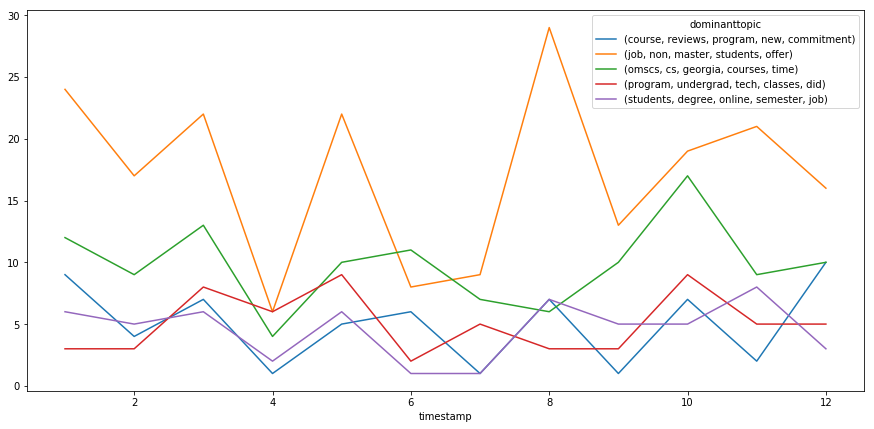

In [105]:
# Make a timeline
df['timestamp'] = df['timestamp'].apply(lambda x : pd.to_datetime(str(x)))
topic_time_count =df.set_index(df.timestamp).loc[:,'dominanttopic']
topic_time_count
topic_day_count = topic_time_count.groupby([topic_time_count.index.month]).value_counts()
topic_day_count.unstack(level=0).T.plot(kind='line',legend=True,figsize=(15, 7))

## From here we can see some of the interesting trends of the topics over the year.
1. In May and August, we can see that there are rising topics in terms of jobs and offers regarding master students
2. In October there is raising trends in the interest for the time and workload of OMSCS students (probably due to the beginning of the new sems)
3. For the overall activities, we can see decline in April but increasing activity in October